In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle
import matplotlib as mpl
mpl.rcdefaults()
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import ConvexHull, QhullError

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score

import umap.umap_ as umap
from scipy.stats import f_oneway


def silhouette_score_cluster(Z, range_k):
    """ Calculate silhouette scores for KMeans, GMM, and Agglomerative Clustering over a range of k.

    Args:
        Z: data matrix to cluster on
        range_k: list of k values to evaluate

    Returns:
        dict with silhouette scores for each method across range_k
    """
    sil_km_scores = []
    sil_gmm_scores = []
    sil_agg_scores = []

    for k in range_k:
        km = KMeans(n_clusters=k, n_init=25, random_state=42)
        gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
        agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
        
        labels_km = km.fit_predict(Z)
        labels_gmm = gmm.fit_predict(Z)
        labels_agg = agg.fit_predict(Z) 
        
        sil_km = silhouette_score(Z, labels_km)
        sil_gmm = silhouette_score(Z, labels_gmm)
        sil_agg = silhouette_score(Z, labels_agg)
        
        sil_km_scores.append(sil_km)
        sil_gmm_scores.append(sil_gmm)
        sil_agg_scores.append(sil_agg)
        
    return {'sil_km_scores': sil_km_scores,
            'sil_gmm_scores': sil_gmm_scores,
            'sil_agg_scores': sil_agg_scores}


def plot_silhouette_lines(range_k, sil_scores, cluster_type):
    """ Plot silhouette scores over a range of k.

    Args:
        range_k: list of k values
        sil_scores: list of silhouette scores corresponding to range_k
        cluster_type: string indicating the clustering method
    """
    plt.figure(figsize=(6,4))
    plt.plot(range_k, sil_scores, marker='o')
    plt.xticks(range_k)
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Silhouette score")
    plt.title(f"Silhouette score by k for {cluster_type}")
    plt.grid(True)
    plt.show()


def draw_region_2d(points2d, ax, facecolor=None, alpha=0.20):
    """ Draw a shaded region around 2D points on the given Axes.

    Args:
        points2d: array-like of shape (n_points, 2)
        ax: matplotlib Axes to draw on
        facecolor: color for the region
        alpha: transparency level
    """
    pts = np.asarray(points2d)
    n = len(pts)
    if n == 0: 
        return
    if n >= 3:
        try:
            hull = ConvexHull(pts)
            hull_pts = pts[hull.vertices]
            ax.fill(hull_pts[:,0], hull_pts[:,1], alpha=alpha, facecolor=facecolor, edgecolor='none')
        except QhullError:
            center = pts.mean(axis=0)
            ell = Ellipse(xy=center, width=0.5, height=0.3, facecolor=facecolor, alpha=alpha, edgecolor='none')
            ax.add_patch(ell)
    elif n == 2:
        a, b = pts[0], pts[1]
        center = (a + b) / 2.0
        vec = b - a
        major = np.linalg.norm(vec)
        angle = np.degrees(np.arctan2(vec[1], vec[0]))
        minor = max(major * 0.25, 0.10)
        ell = Ellipse(xy=center, width=major*1.06, height=minor*1.06,
                    angle=angle, facecolor=facecolor, alpha=alpha, edgecolor='none')
        ax.add_patch(ell)
    else:
        circ = Circle(pts[0], radius=0.15, facecolor=facecolor, alpha=alpha, edgecolor='none')
        ax.add_patch(circ)

def draw_region_3d(points3d, ax3d, facecolor=None, alpha=0.15):
    """ Draw a shaded convex hull around 3D points on the given 3D Axes.

    Args:
        points3d: array-like of shape (n_points, 3)
        ax3d: matplotlib 3D Axes to draw on
        facecolor: color for the region
        alpha: transparency level
    """
    pts = np.asarray(points3d)
    if len(pts) < 4:
        return
    try:
        hull = ConvexHull(pts)
        verts = [pts[simplex] for simplex in hull.simplices]
        poly = Poly3DCollection(verts, alpha=alpha)
        if facecolor is not None:
            poly.set_facecolor(facecolor)
            poly.set_edgecolor('none')
        ax3d.add_collection3d(poly)
    except QhullError:
        pass

# ---------- projections ----------
def project_2d_3d(X, proj2='pca', random_state=42):
    """ Project data X into 2D and 3D spaces.

    Args:
        X: data matrix (n_samples x n_features)
        proj2: 'pca' or 'umap' for 2D projection method
        random_state: random seed for reproducibility

    Returns:
        X2: 2D projected data
        X3: 3D projected data
    """
    if proj2 == 'pca':
        X2 = PCA(n_components=2, random_state=random_state).fit_transform(X)
    else:
        X2 = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=random_state).fit_transform(X)
    X3 = PCA(n_components=3, random_state=random_state).fit_transform(X)
    return X2, X3


# ---------- clustering ----------
def fit_cluster(X, method, k, random_state=42):
    """ Fit clustering model to data X using specified method and number of clusters k.

    Args:
        X: data matrix (n_samples x n_features)
        method: 'kmeans', 'gmm', or 'agglo' for clustering method
        k: number of clusters
        random_state: random seed for reproducibility

    Raises:
        ValueError: if method is not recognized

    Returns:
        labels: cluster labels for each sample
        model: fitted clustering model
        metrics: dict of clustering metrics (silhouette, inertia, BIC, AIC)
        
    """
    if method == "kmeans":
        model = KMeans(n_clusters=k, n_init=25, random_state=random_state).fit(X)
        labels = model.labels_
        return labels, model, {"silhouette": silhouette_score(X, labels), "inertia": model.inertia_}
    if method == "gmm":
        model = GaussianMixture(n_components=k, covariance_type="full", random_state=random_state).fit(X)
        labels = model.predict(X)
        return labels, model, {
            "silhouette": silhouette_score(X, labels),
            "bic": model.bic(X),
            "aic": model.aic(X)
        }
    if method == "agglo":
        model = AgglomerativeClustering(n_clusters=k, linkage="ward").fit(X)
        labels = model.labels_
        return labels, model, {"silhouette": silhouette_score(X, labels)}
    raise ValueError("method must be one of {'kmeans','gmm','agglo'}")

_GLOBAL_CLUSTER_PALETTE = (
    list(plt.get_cmap('tab20').colors) +
    list(plt.get_cmap('tab20b').colors) +
    list(plt.get_cmap('tab20c').colors)
)

def color_for_cluster_id(cluster_id: int):
    """ Deterministically map any integer cluster id -> an RGBA color.
    Args:
        cluster_id: integer cluster id
    Returns:
        RGBA color tuple
    """
    palette = _GLOBAL_CLUSTER_PALETTE
    return palette[int(cluster_id) % len(palette)]

def make_cluster_colors_for_labels(labels):
    """ Create a mapping from cluster ids in labels to colors. 
    Args:
        labels: array-like of cluster labels. (any subset like {0,1,2} or {0..k-1})

    Returns:
        dict mapping cluster id -> RGBA color. {cluster_id: color} using the global palette.
    """
    clusters = sorted(np.unique(labels))
    return {cl: color_for_cluster_id(cl) for cl in clusters}

# ---------- silhouette plot ----------
def plot_silhouette(X, labels, title=None, cluster_colors=None):
    """ Plot silhouette values for each cluster.

    Args:
        X: data matrix (n_samples x n_features)
        labels: array-like of cluster labels
        title: str, optional title for the plot
        cluster_colors: dict mapping cluster id -> RGBA color, optional
    """
    labels = np.asarray(labels)
    clusters = sorted(np.unique(labels))
    if len(clusters) < 2:
        print("Silhouette plot needs at least 2 clusters.")
        return

    sil_values = silhouette_samples(X, labels)
    sil_avg = sil_values.mean()
    x_min = min(-0.1, sil_values.min() - 0.05)
    x_max = 1.0

    fig, ax = plt.subplots(figsize=(6,5))
    y_lower = 10
    for cl in clusters:
        vals = np.sort(sil_values[labels == cl])
        size = vals.shape[0]
        y_upper = y_lower + size
        color = (cluster_colors[cl] if cluster_colors is not None else color_for_cluster_id(cl))
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, vals,
                        facecolor=color, alpha=0.7, edgecolor='none')
        ax.text(x_min + 0.02, y_lower + 0.5*size, f"Cluster {cl}")
        y_lower = y_upper + 10

    ax.axvline(sil_avg, linestyle="--", linewidth=1)
    ax.set_xlim([x_min, x_max])
    ax.set_xlabel("Silhouette coefficient")
    ax.set_yticks([])
    if title:
        ax.set_title(f"{title} — avg = {sil_avg:.3f}")
    plt.tight_layout(); plt.show()

# ---------- 2D + 3D plot ----------
def plot_2d_3d(X2, X3, labels, cohorts, title_prefix="Clusters", cluster_colors=None):
    """ Plot 2D and 3D scatter plots of data points colored by cohort, with shaded cluster regions.

    Args:
        X2: 2D data matrix (n_samples x 2)
        X3: 3D data matrix (n_samples x 3)
        labels: array-like of cluster labels
        cohorts: array-like of cohort labels for coloring points
        title_prefix: str prefix for plot titles
        cluster_colors: dict mapping cluster id -> RGBA color, optional
    """
    cohorts = pd.Series(cohorts).astype('category')
    categories = cohorts.cat.categories
    uniq_clusters = sorted(np.unique(labels))

    cohort_cmap = plt.cm.tab10  # choose cohort colors independently

    # ensure we have a cluster color for every id
    if cluster_colors is None:
        cluster_colors = {cl: color_for_cluster_id(cl) for cl in uniq_clusters}

    fig = plt.figure(figsize=(12,5))
    ax2d = fig.add_subplot(1,2,1)
    ax3d = fig.add_subplot(1,2,2, projection='3d')

    # 2D points (cohort colors)
    for i, c in enumerate(categories):
        m = (cohorts == c).to_numpy()
        ax2d.scatter(X2[m,0], X2[m,1], s=40, alpha=0.85, edgecolor='k',
                    label=str(c), c=[cohort_cmap(i % cohort_cmap.N)])

    # 2D shaded cluster regions (cluster colors)
    for cl in uniq_clusters:
        m = (labels == cl)
        draw_region_2d(X2[m], ax2d, facecolor=cluster_colors[cl], alpha=0.20)

    ax2d.set_xlabel("PC1"); ax2d.set_ylabel("PC2")
    ax2d.set_title(f"{title_prefix} (2D projection)")
    ax2d.legend(title="Cohort", bbox_to_anchor=(1.05,1), loc='upper left')
    ax2d.grid(True)

    # 3D points (cohort colors)
    for i, c in enumerate(categories):
        m = (cohorts == c).to_numpy()
        ax3d.scatter(X3[m,0], X3[m,1], X3[m,2], s=20, alpha=0.9,
                    c=[cohort_cmap(i % cohort_cmap.N)], depthshade=False, label=None)

    # 3D shaded cluster hulls (cluster colors)
    for cl in uniq_clusters:
        m = (labels == cl)
        draw_region_3d(X3[m], ax3d, facecolor=cluster_colors[cl], alpha=0.15)

    ax3d.set_xlabel("PC1"); ax3d.set_ylabel("PC2"); ax3d.set_zlabel("PC3")
    ax3d.set_title(f"{title_prefix} (3D PCA)")
    ax3d.view_init(elev=20, azim=35)
    plt.tight_layout(); plt.show()


def kmeans_effect_matrix(df_feat: pd.DataFrame, labels, use_hedges_g: bool = True, eps: float = 1e-12) -> pd.DataFrame:
    """ Compute effect size matrix (Hedges' g) for KMeans clusters. 

    Args:
        df_feat: DataFrame of features (rows=samples, cols=features)
        labels: array-like of cluster labels
        use_hedges_g: whether to apply Hedges' g correction
        eps: small value to avoid division by zero

    Returns:
        DataFrame of effect sizes (rows=features, cols=clusters)
    """
    labels = np.asarray(labels)
    clusters = np.unique(labels)
    X = df_feat.values
    cols = df_feat.columns

    effect_cols = {}
    for c in clusters:
        m = labels == c
        A, B = X[m], X[~m]
        nA, nB = A.shape[0], B.shape[0]

        muA, muB = A.mean(axis=0), B.mean(axis=0)
        varA = A.var(axis=0, ddof=1) if nA > 1 else np.zeros_like(muA)
        varB = B.var(axis=0, ddof=1) if nB > 1 else np.zeros_like(muB)

        df_total = max(nA + nB - 2, 1)
        sd_pooled = np.sqrt(((max(nA-1,0)*varA + max(nB-1,0)*varB) / df_total) + eps)
        d = (muA - muB) / sd_pooled  # signed effect

        if use_hedges_g and df_total > 1:
            J = 1.0 - (3.0 / (4.0*df_total - 1.0))
            d = d * J

        effect_cols[f"cluster_{int(c)}"] = d

    return pd.DataFrame(effect_cols, index=cols)  # rows=features, cols=clusters


def kmeans_top_features(df_feat: pd.DataFrame, labels, top_n: int = 5, use_hedges_g: bool = True):
    """ Identify top N features per KMeans cluster based on effect sizes.

    Args:
        df_feat: DataFrame of features (rows=samples, cols=features)
        labels: array-like of cluster labels
        top_n: number of top features to select per cluster
        use_hedges_g: whether to apply Hedges' g correction

    Returns:
        effect_df: DataFrame of effect sizes (rows=features, cols=clusters)
        top_feats: dict mapping cluster id -> list of top feature names
        top_feats_df: DataFrame of top features per cluster
    """
    effect_df = kmeans_effect_matrix(df_feat, labels, use_hedges_g=use_hedges_g)
    top_feats = {
        cl: effect_df[cl].abs().nlargest(top_n).index.tolist()
        for cl in effect_df.columns
    }
    top_feats_df = pd.DataFrame(top_feats) # rows=top_n, cols=clusters
    return effect_df, top_feats, top_feats_df


def plot_effect_bars_per_cluster(effect_df: pd.DataFrame, top_feats: dict, title_prefix: str = "KMeans"):
    """
    effect_df: feature x cluster effect sizes (signed)
    top_feats: dict {'cluster_0': [feat,...], ...}
    """
    for cl, feats in top_feats.items():
        s = effect_df[cl].loc[feats]  # signed effects for this cluster’s top features
        # order bars by absolute effect (largest on top)
        s = s.reindex(s.abs().sort_values(ascending=True).index)  # ascending

        fig, ax = plt.subplots(figsize=(6, 0.6*len(s) + 1.5))
        bars = ax.barh(s.index, s.values)
        # color by sign
        for b, v in zip(bars, s.values):
            b.set_color("#2ca02c" if v > 0 else "#d62728")
            b.set_alpha(0.85)

        ax.axvline(0, color='k', linewidth=1)
        ax.set_xlabel("Signed effect (Hedges' g)")
        ax.set_title(f"{title_prefix} — {cl}: top features")
        plt.tight_layout()
        plt.show()


def cluster_and_plot_all(
    df, feature_cols, cohort_col,
    methods=("kmeans","gmm","agglo"),
    ks=(2,3,4),
    proj2='pca',
    cluster_on_pca_var=None,
    random_state=42,
    show_silhouette=True,
    do_feature_profiles=True,
    profile_top_n=5,
):
    """ Cluster data and generate plots for each method and k.

    Args:
        df: DataFrame with features and cohort info
        feature_cols: list of feature column names
        cohort_col: name of cohort column
        methods: tuple of clustering methods to use
        ks: tuple of k values to evaluate
        proj2: projection method for 2D ('pca' or 'umap')
        cluster_on_pca_var: float or None, variance threshold for PCA clustering 
        random_state: random seed for reproducibility
        show_silhouette: whether to plot silhouette plots 
        do_feature_profiles: whether to compute feature profiles for KMeans
        profile_top_n: number of top features to profile per cluster

    Returns:
        DataFrame summarizing clustering results and metrics
    """
    X_std = df[feature_cols].values

    # choose feature space for clustering
    if cluster_on_pca_var is None:
        X_fit = X_std
        fit_space_descr = "stadndardized features"
    else:
        p = PCA(n_components=None, random_state=random_state).fit(X_std)
        csum = np.cumsum(p.explained_variance_ratio_)
        n_keep = np.searchsorted(csum, cluster_on_pca_var) + 1
        X_fit = p.transform(X_std)[:, :n_keep]
        fit_space_descr = f"PCA({n_keep} comps, {cluster_on_pca_var:.0%} var)"

    # 2D & 3D projections for visualization
    X2, X3 = project_2d_3d(X_std, proj2=proj2, random_state=random_state)

    rows = []
    for method in methods:
        for k in ks:
            labels, model, metrics = fit_cluster(X_fit, method, k, random_state=random_state)
            title = f"{method.upper()} (k={k}) — clustered on {fit_space_descr}"
            
            cluster_colors = make_cluster_colors_for_labels(labels)
            
            # panels
            plot_2d_3d(X2, X3, labels, df[cohort_col], title_prefix=title, cluster_colors=cluster_colors)

            # silhouette
            if show_silhouette:
                plot_silhouette(X_fit, labels, title=title, cluster_colors=cluster_colors)

            if do_feature_profiles and profile_top_n > 0:
                if method == "kmeans":
                    df_feat = pd.DataFrame(X_std, columns=feature_cols, index=df.index)

                    effect_df, top_feats, top_feats_df = kmeans_top_features(
                        df_feat=df_feat,
                        labels=labels,
                        top_n=profile_top_n,
                        use_hedges_g=True
                    )

                    display(top_feats_df)

                    plot_effect_bars_per_cluster(
                        effect_df=effect_df,
                        top_feats=top_feats,
                        title_prefix=f"{method.upper()} (k={k})"
                    )
                    
            row = {"method": method, "k": k, "fit_space": fit_space_descr}
            row.update(metrics)
            rows.append(row)
            df[f"{method}_{k}_label"] = labels

    # sort report by silhouette (desc)
    return pd.DataFrame(rows).sort_values(by="silhouette", ascending=False)


In [2]:
Z_df = pd.read_excel('output_data/transformed_residualized_features_imputed.xlsx')
range_k = range(2, 9)
Z_df_no_metadata = Z_df.drop(columns=['combined_ID', 'source'])
Z_df_only_gi_feat = Z_df_no_metadata.drop(columns=['SBTT__scaled', 'AGE__scaled', 'Sex_bin', 'cohort'])

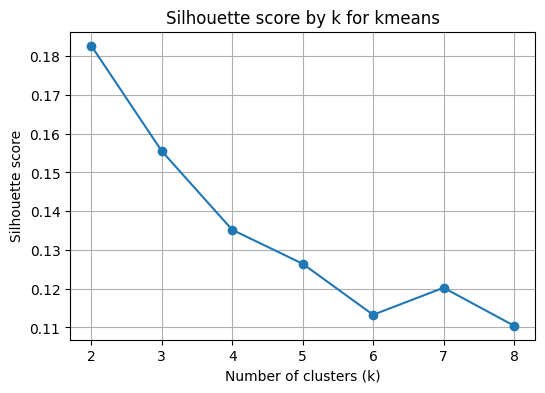

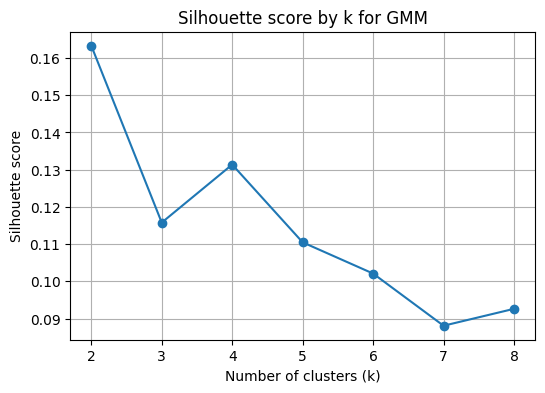

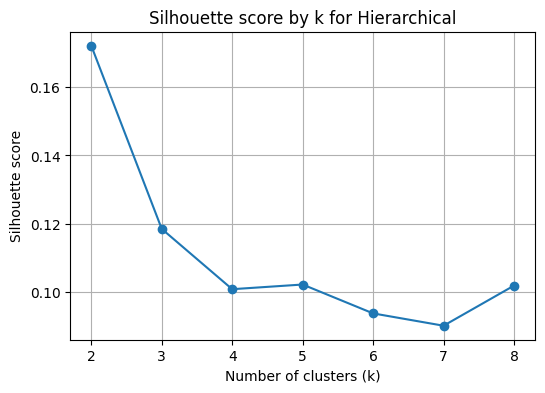

In [5]:
cluster_silhouette_scores = silhouette_score_cluster(Z_df_only_gi_feat, range_k)
plot_silhouette_lines(range_k, cluster_silhouette_scores['sil_km_scores'], cluster_type='kmeans')
plot_silhouette_lines(range_k, cluster_silhouette_scores['sil_gmm_scores'], cluster_type='GMM')
plot_silhouette_lines(range_k, cluster_silhouette_scores['sil_agg_scores'], cluster_type='Hierarchical')

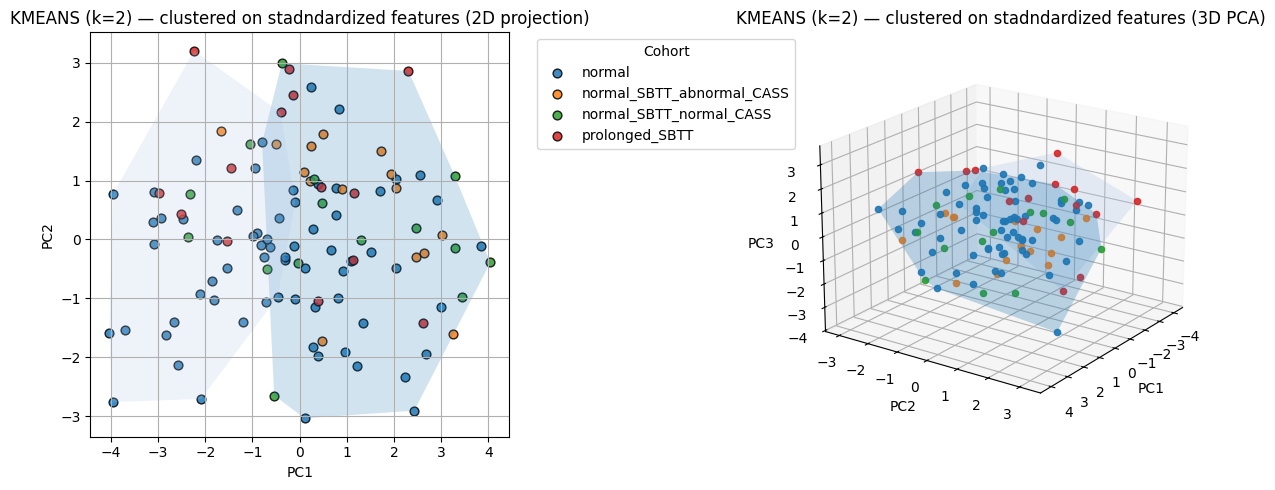

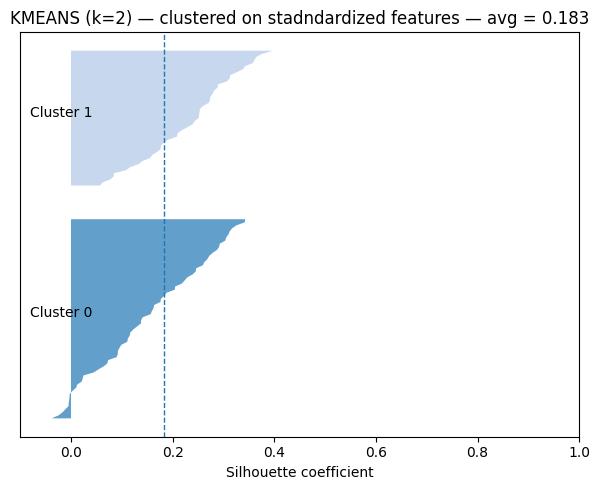

cluster_0  \
0  number_of_contractions_over26.7_per_hour__scaled   
1              total_contractions_frequency__scaled   
2             total_contraction_rate_over10__scaled   
3        median_RMSSD_Magnitude_total_epoch__scaled   
4             median_RMSSD_Time_total_epoch__scaled   

                                          cluster_1  
0  number_of_contractions_over26.7_per_hour__scaled  
1              total_contractions_frequency__scaled  
2             total_contraction_rate_over10__scaled  
3        median_RMSSD_Magnitude_total_epoch__scaled  
4             median_RMSSD_Time_total_epoch__scaled

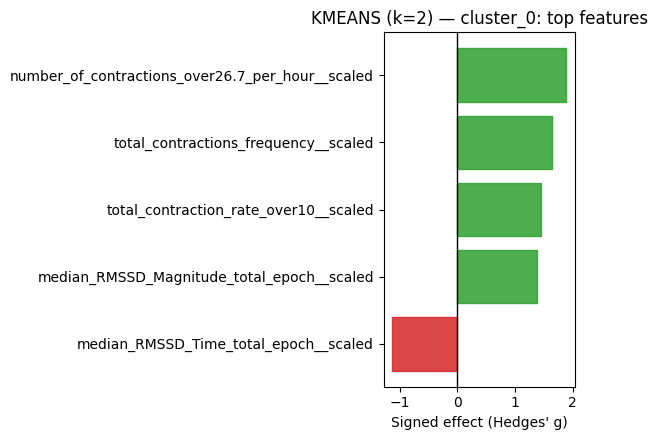

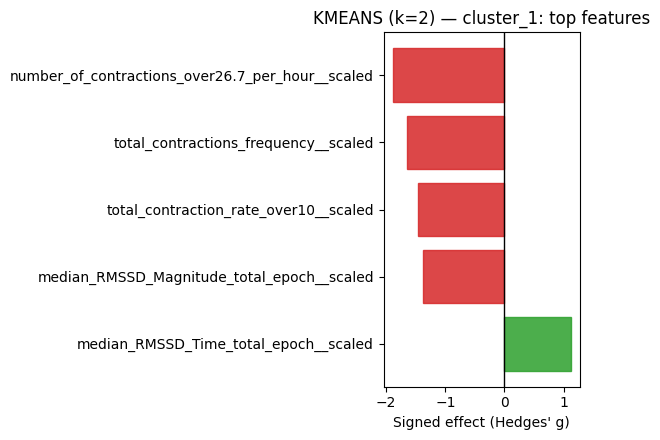

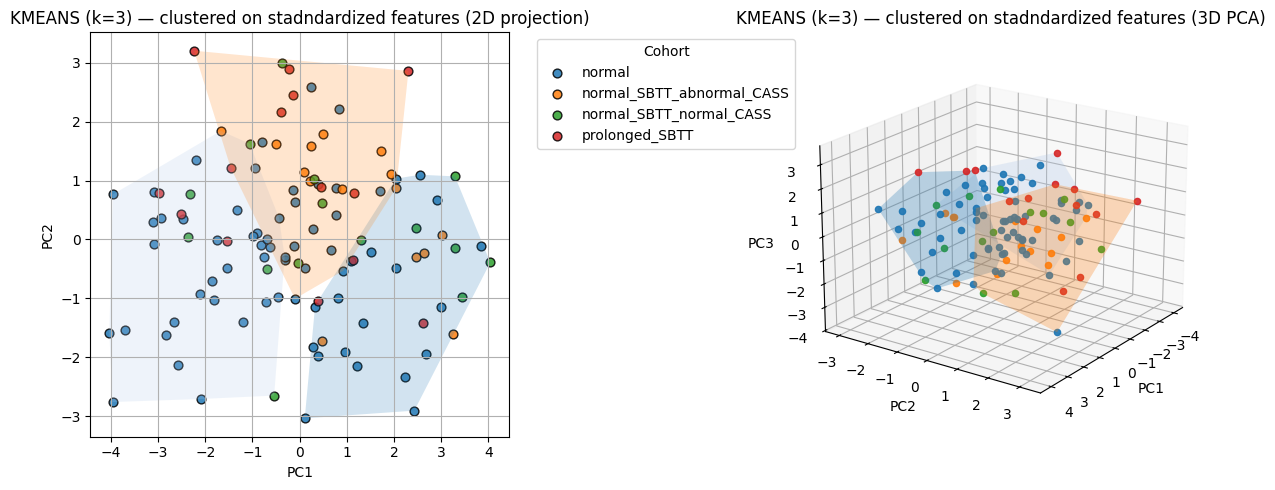

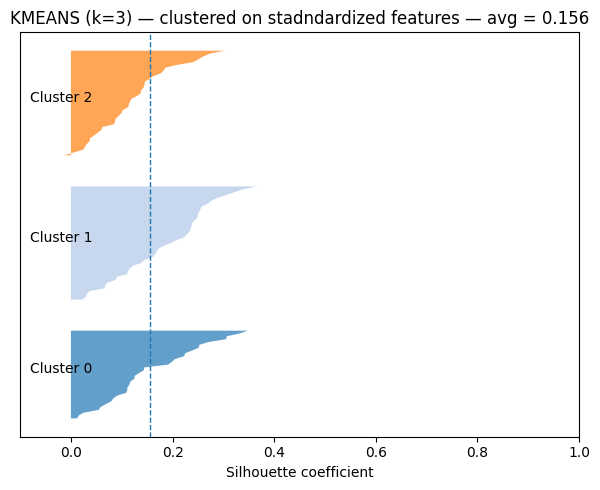

cluster_0  \
0      total_contractions_frequency__scaled   
1                    motility_index__scaled   
2     median_RMSSD_Time_total_epoch__scaled   
3     total_contraction_rate_over10__scaled   
4  number_of_total_epochs_frequency__scaled   

                                          cluster_1  \
0  number_of_contractions_over26.7_per_hour__scaled   
1        median_RMSSD_Magnitude_total_epoch__scaled   
2              total_contractions_frequency__scaled   
3             total_contraction_rate_over10__scaled   
4                            motility_index__scaled   

                                          cluster_2  
0        median_RMSSD_Magnitude_total_epoch__scaled  
1              median_RMSSD_Time_slow epoch__scaled  
2  number_of_contractions_over26.7_per_hour__scaled  
3            median_RMSSD_Time_medium epoch__scaled  
4              median_RMSSD_Time_fast epoch__scaled

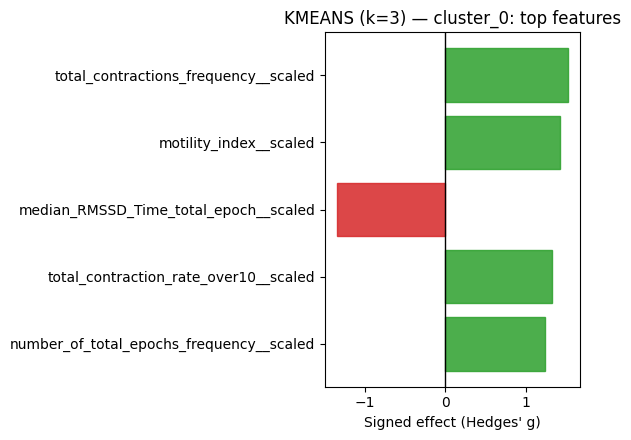

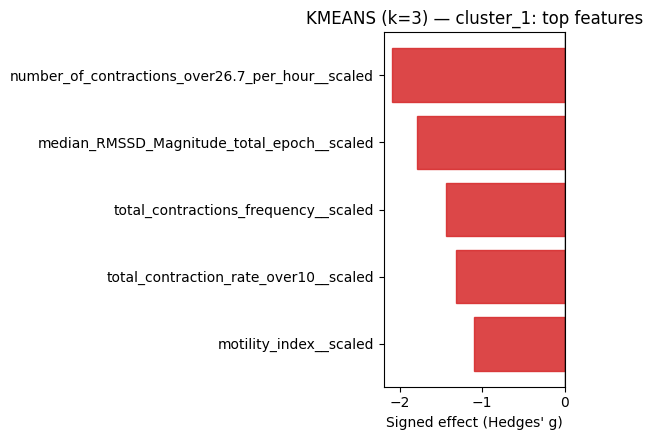

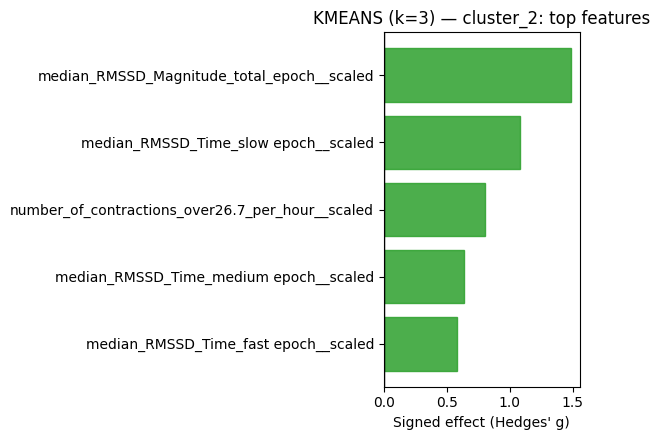

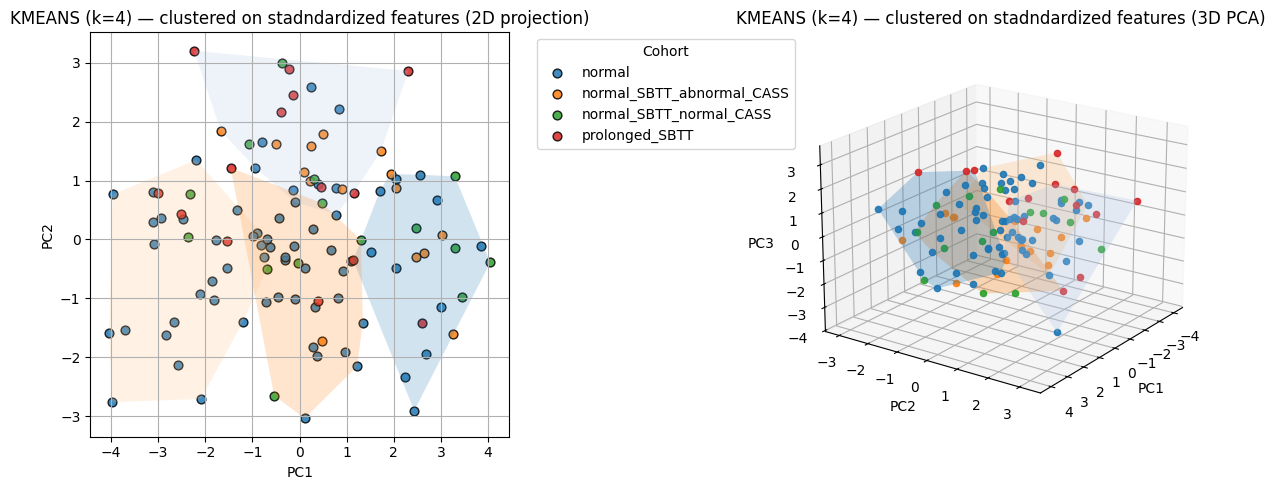

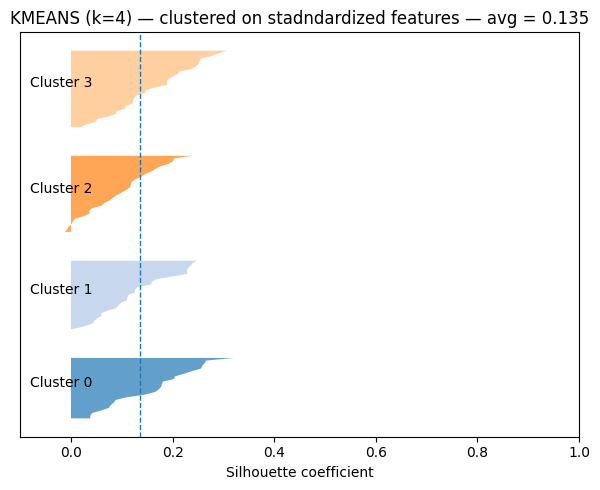

cluster_0  \
0              total_contractions_frequency__scaled   
1             total_contraction_rate_over10__scaled   
2                            motility_index__scaled   
3          number_of_total_epochs_frequency__scaled   
4  number_of_contractions_over26.7_per_hour__scaled   

                                    cluster_1  \
0      median_RMSSD_Time_medium epoch__scaled   
1        median_RMSSD_Time_fast epoch__scaled   
2       median_RMSSD_Time_total_epoch__scaled   
3        median_RMSSD_Time_slow epoch__scaled   
4  median_RMSSD_Magnitude_total_epoch__scaled   

                                  cluster_2  \
0    median_RMSSD_Time_medium epoch__scaled   
1      median_RMSSD_Time_fast epoch__scaled   
2     median_RMSSD_Time_total_epoch__scaled   
3          imputed_sum_of_amplitude__scaled   
4  number_of_total_epochs_frequency__scaled   

                                          cluster_3  
0  number_of_contractions_over26.7_per_hour__scaled  
1              total_contractions_frequency__scaled  
2             total_contraction_rate_over10__scaled  
3        median_RMSSD_Magnitude_total_epoch__scaled  
4                            motility_index__scaled

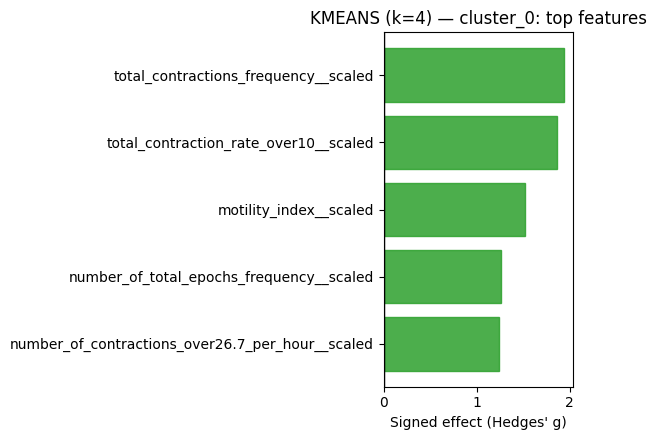

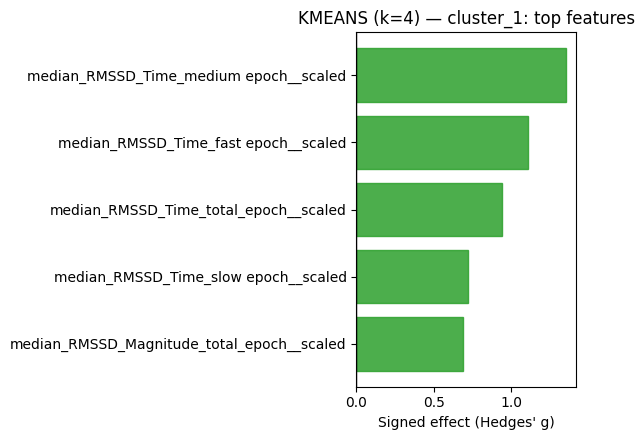

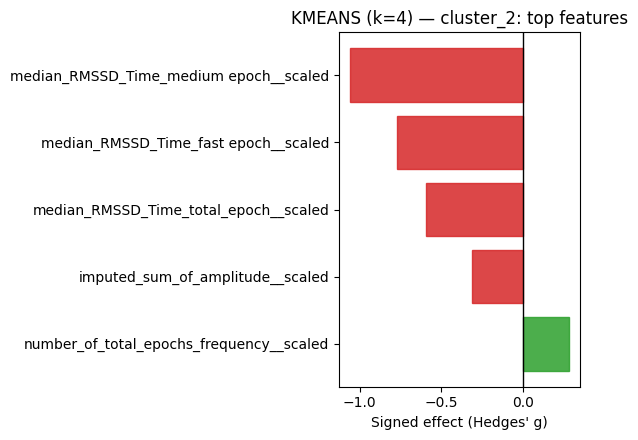

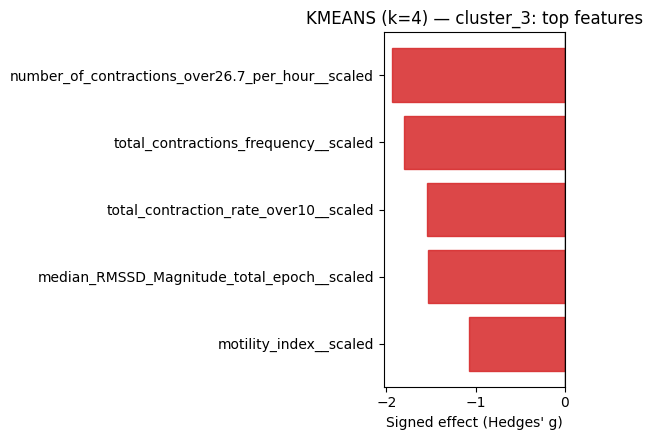

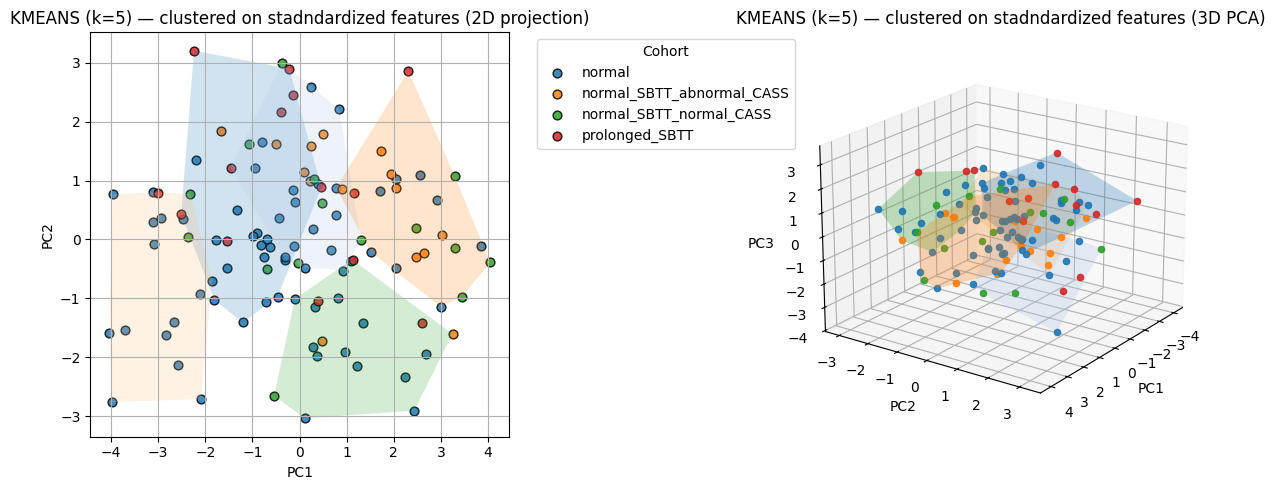

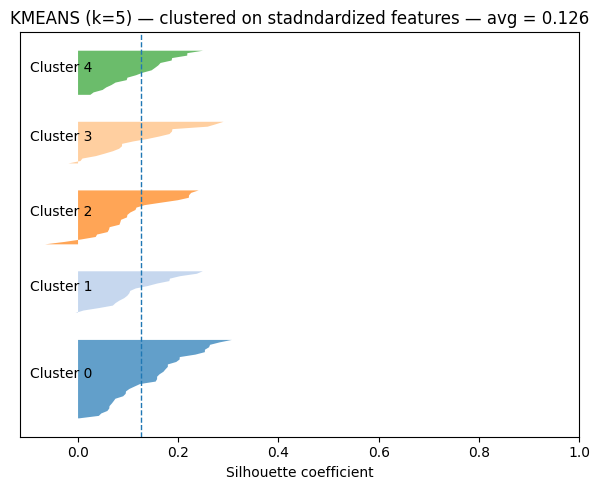

cluster_0  \
0             median_RMSSD_Time_total_epoch__scaled   
1  number_of_contractions_over26.7_per_hour__scaled   
2              median_RMSSD_Time_fast epoch__scaled   
3        median_RMSSD_Magnitude_total_epoch__scaled   
4             total_contraction_rate_over10__scaled   

                                          cluster_1  \
0              median_RMSSD_Time_slow epoch__scaled   
1        median_RMSSD_Magnitude_total_epoch__scaled   
2  number_of_contractions_over26.7_per_hour__scaled   
3                            motility_index__scaled   
4                  imputed_sum_of_amplitude__scaled   

                                          cluster_2  \
0  number_of_contractions_over26.7_per_hour__scaled   
1              total_contractions_frequency__scaled   
2                            motility_index__scaled   
3                  imputed_sum_of_amplitude__scaled   
4             total_contraction_rate_over10__scaled   

                                          cluster_3  \
0              total_contractions_frequency__scaled   
1                            motility_index__scaled   
2  number_of_contractions_over26.7_per_hour__scaled   
3                  imputed_sum_of_amplitude__scaled   
4             total_contraction_rate_over10__scaled   

                                cluster_4  
0   median_RMSSD_Time_total_epoch__scaled  
1  median_RMSSD_Time_medium epoch__scaled  
2    median_RMSSD_Time_fast epoch__scaled  
3                  motility_index__scaled  
4    median_RMSSD_Time_slow epoch__scaled

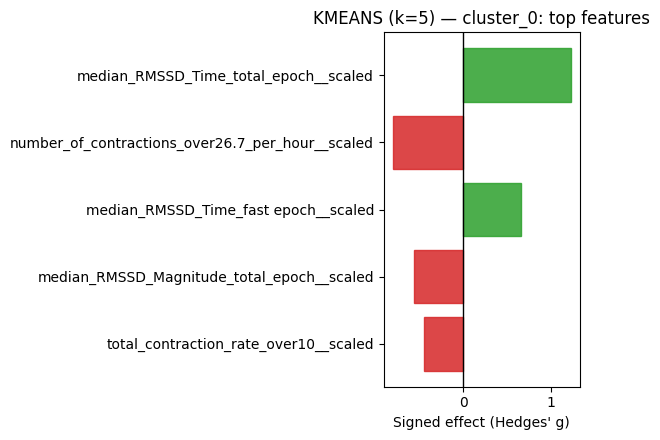

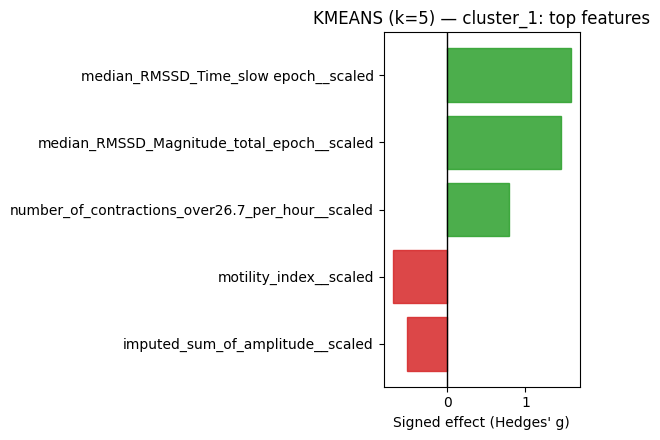

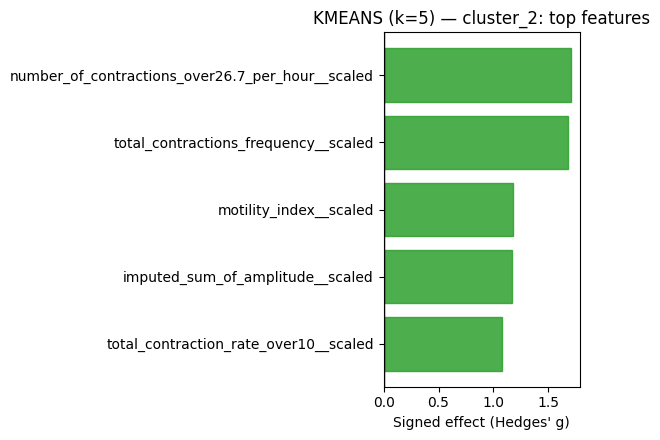

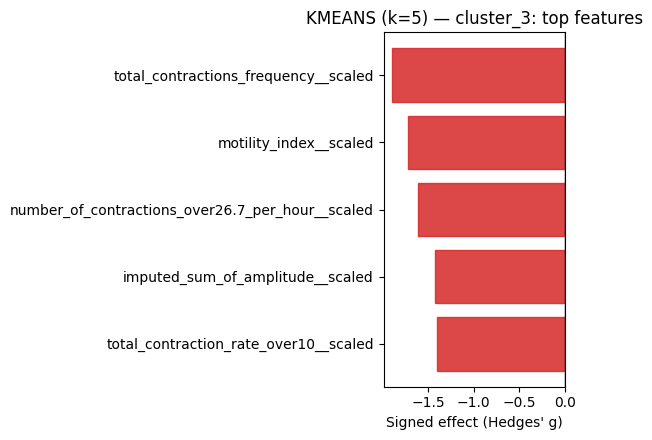

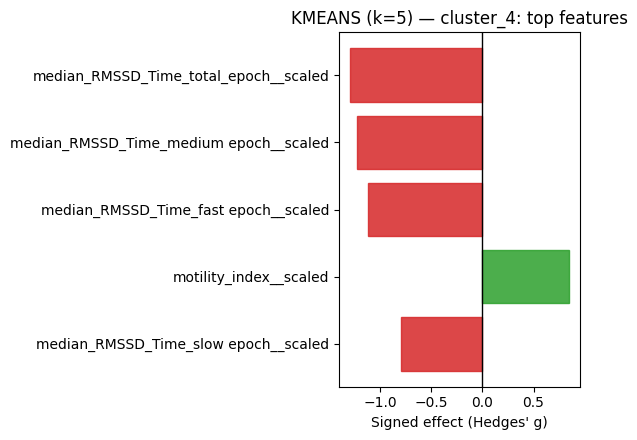

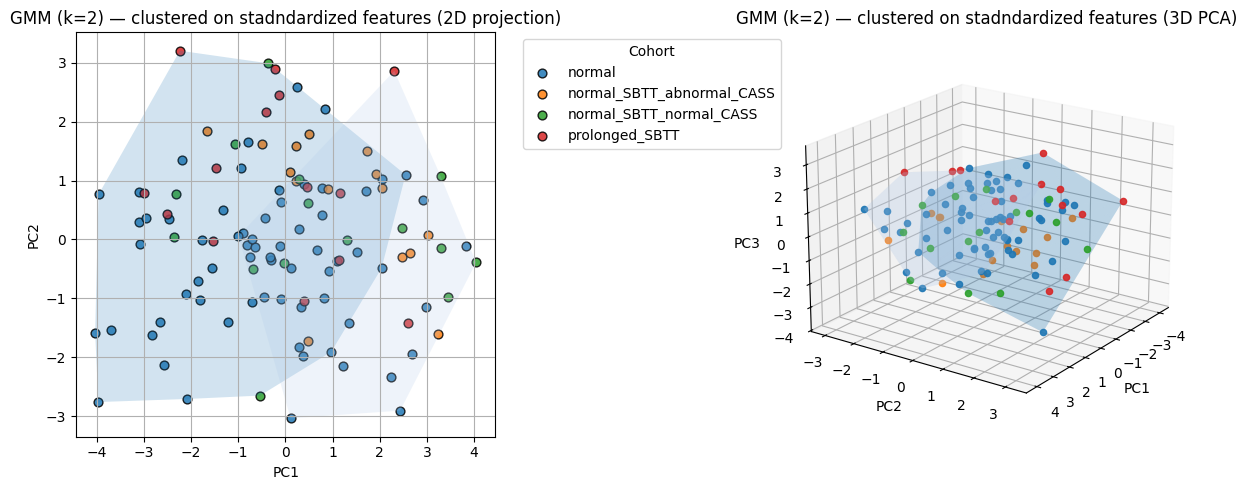

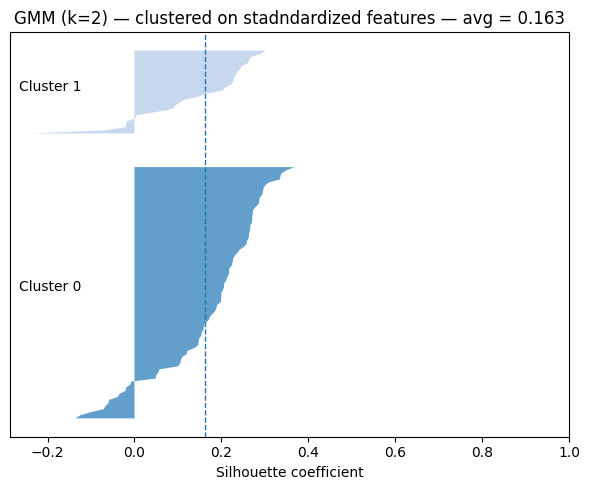

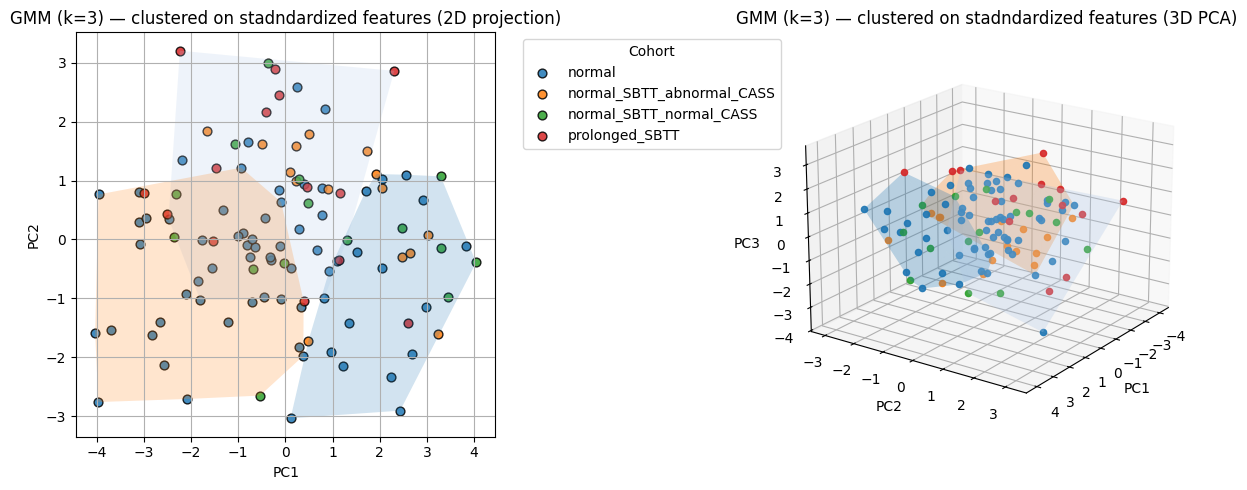

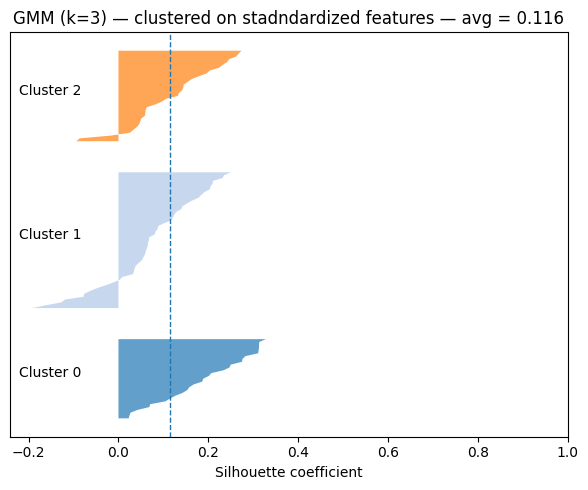

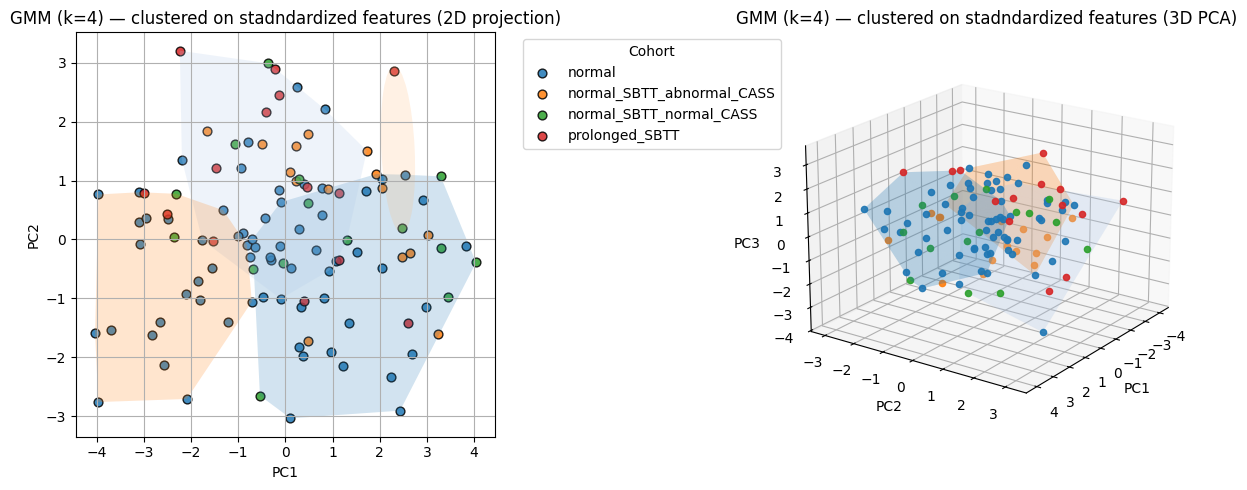

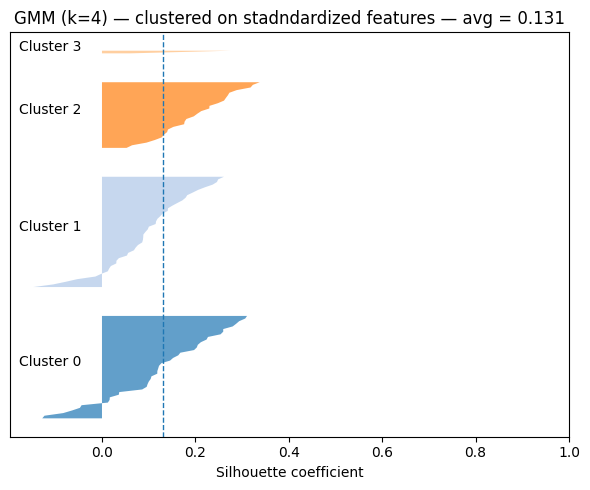

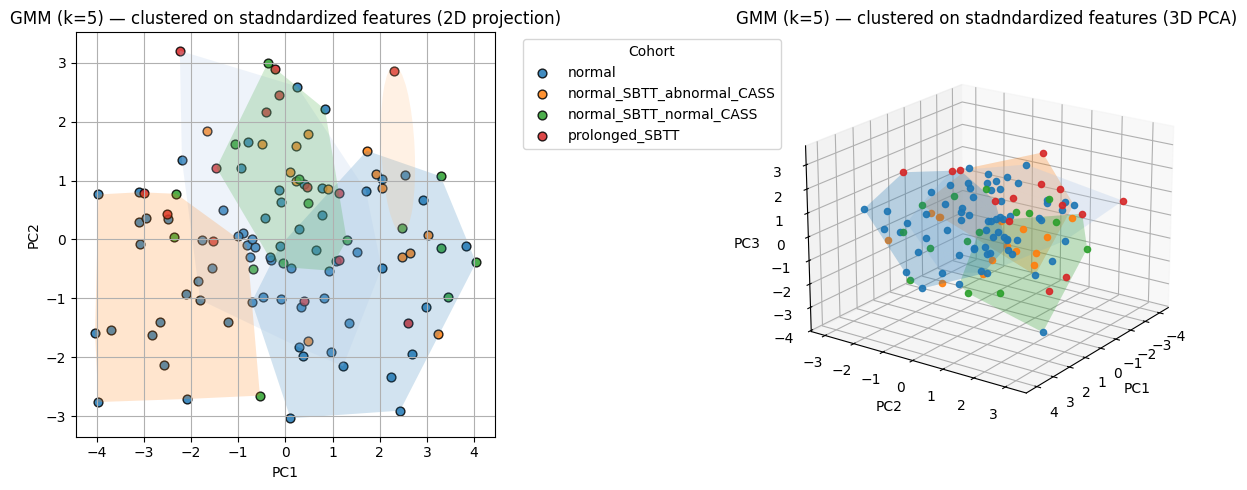

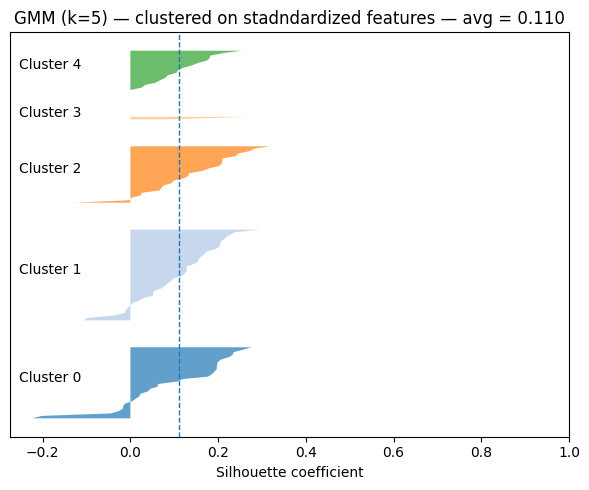

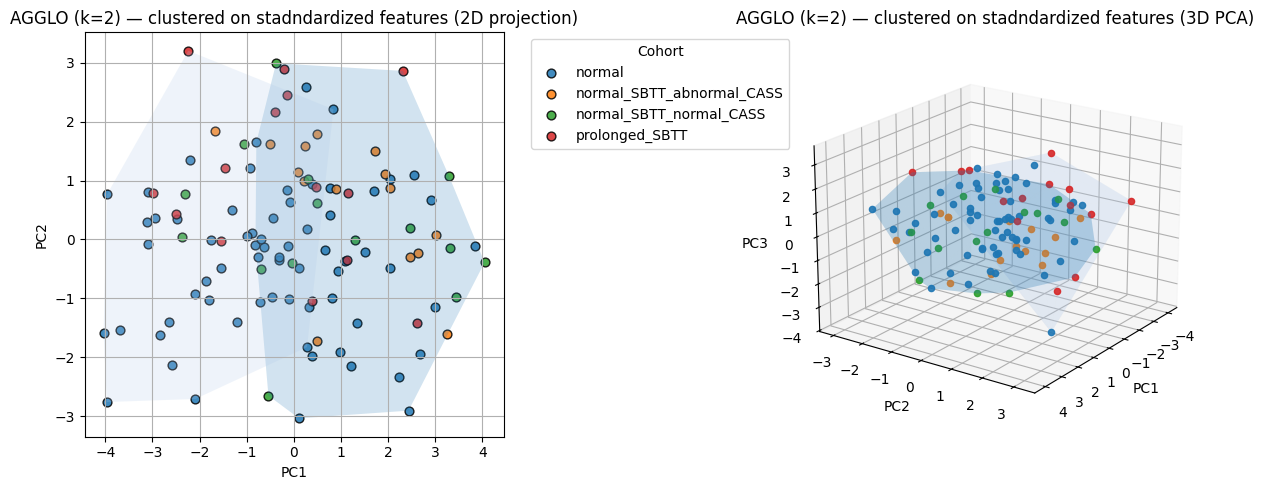

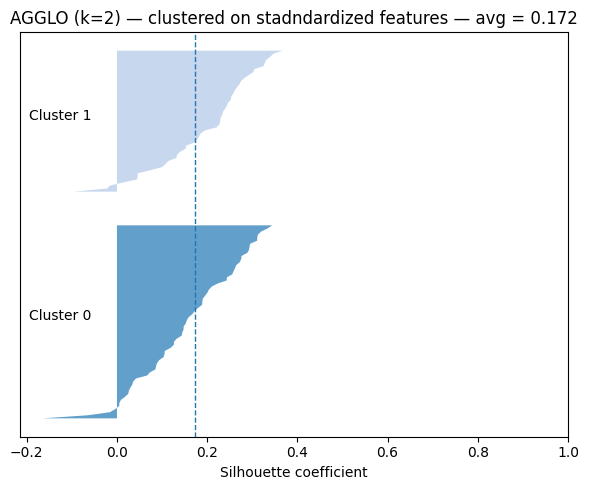

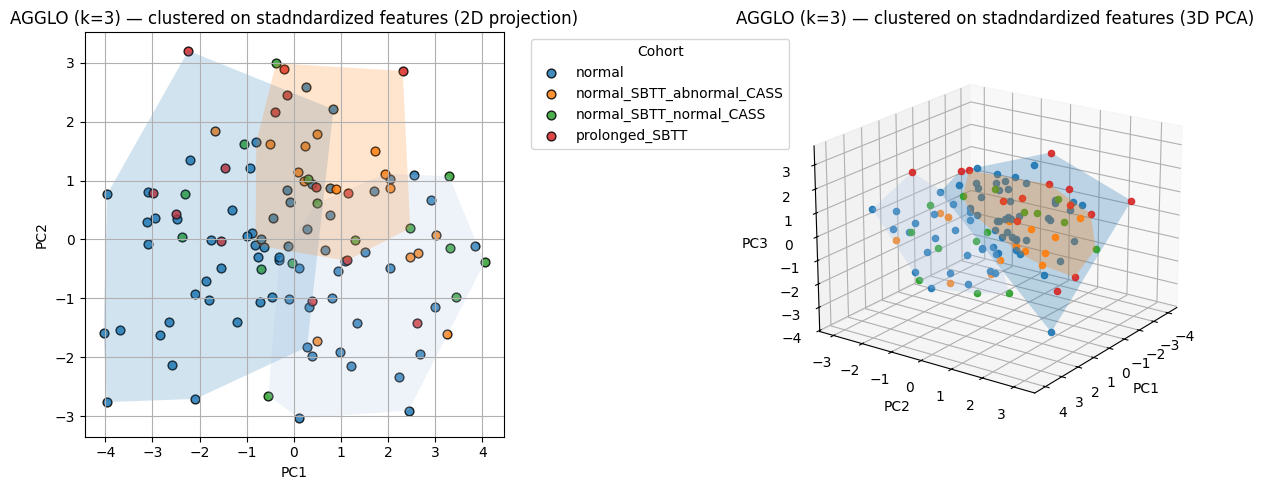

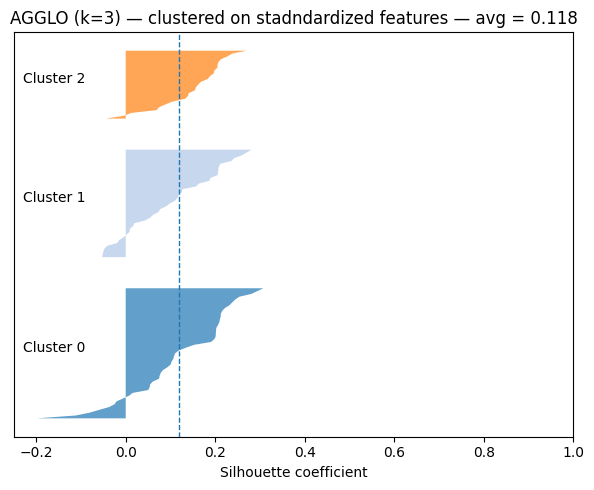

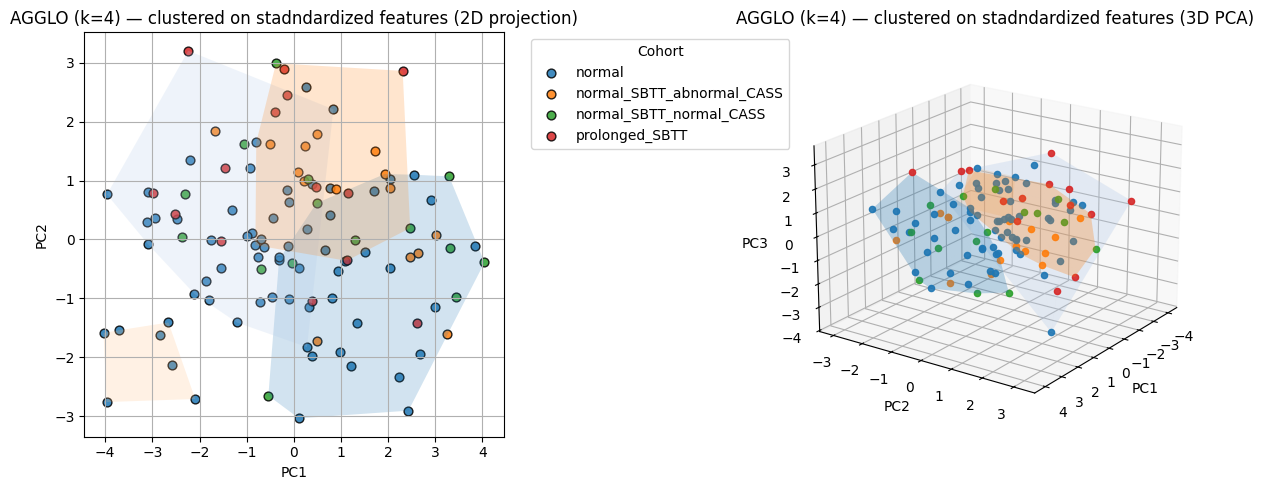

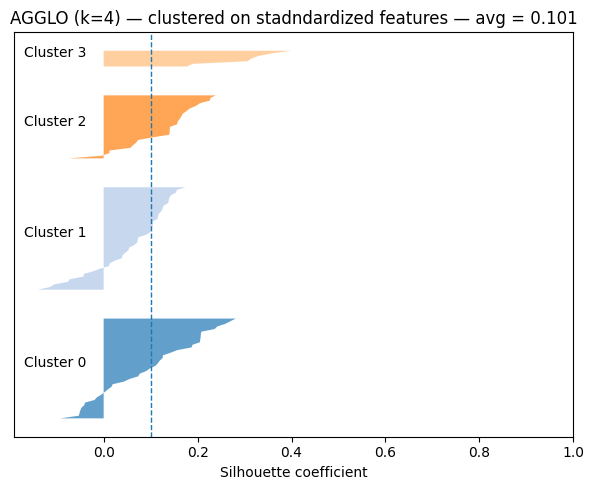

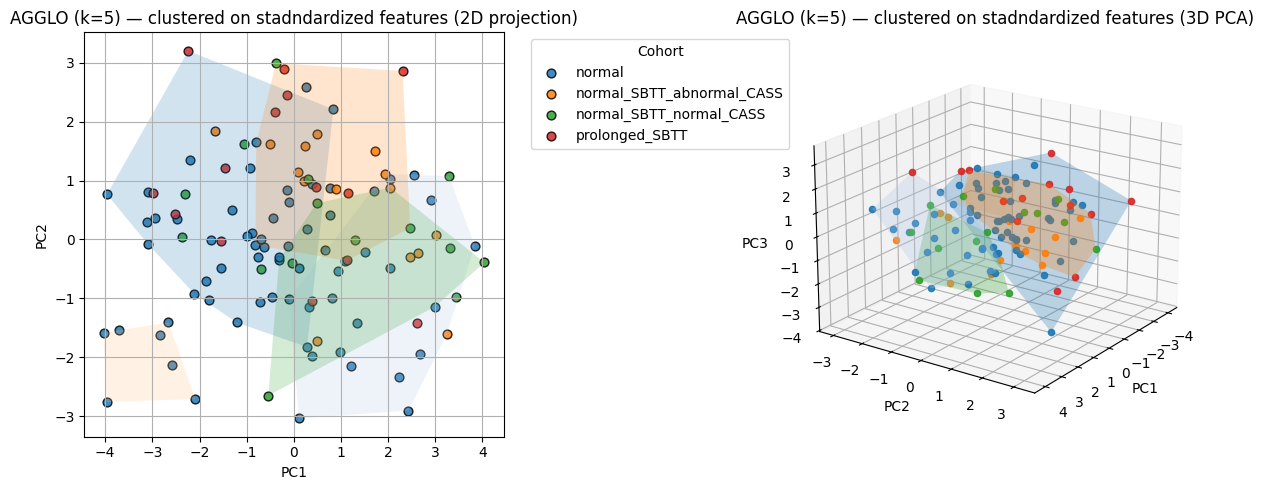

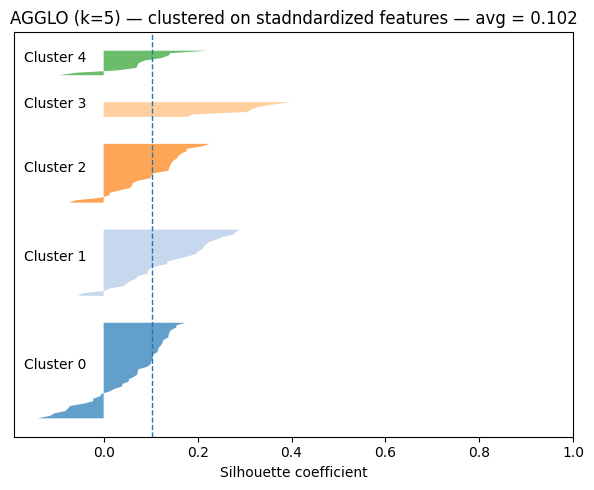

In [552]:
gi_features = Z_df_only_gi_feat.columns.tolist()
cohort_col  = "cohort"

summary = cluster_and_plot_all(
    Z_df_no_metadata, gi_features, cohort_col,
    methods=("kmeans","gmm","agglo"),
    ks=(2,3,4,5),
    proj2='pca',                 
    cluster_on_pca_var=None,   
    show_silhouette=True,
    do_feature_profiles=True,
    profile_top_n=5
)

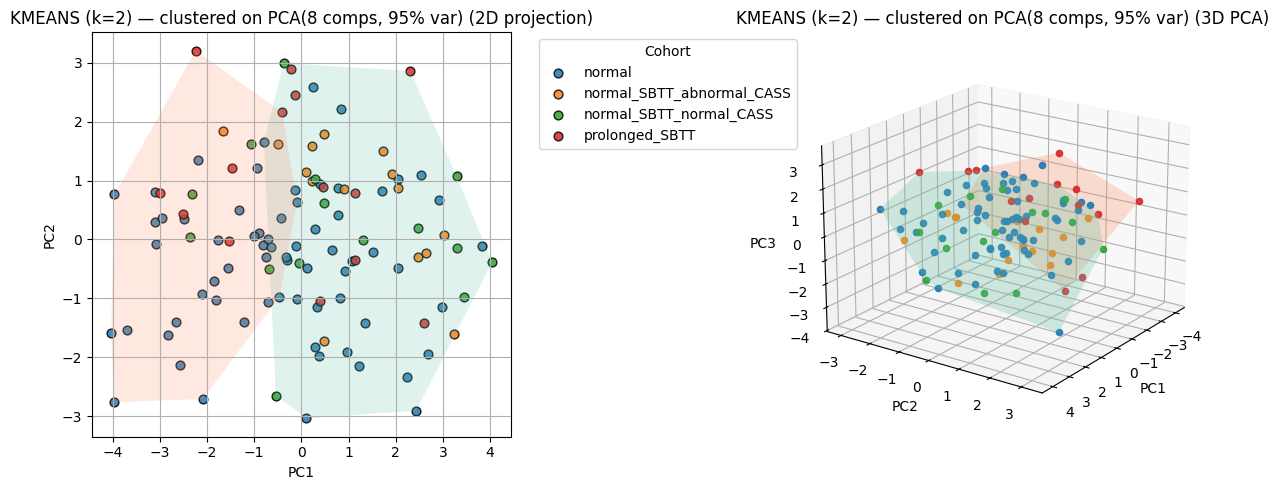

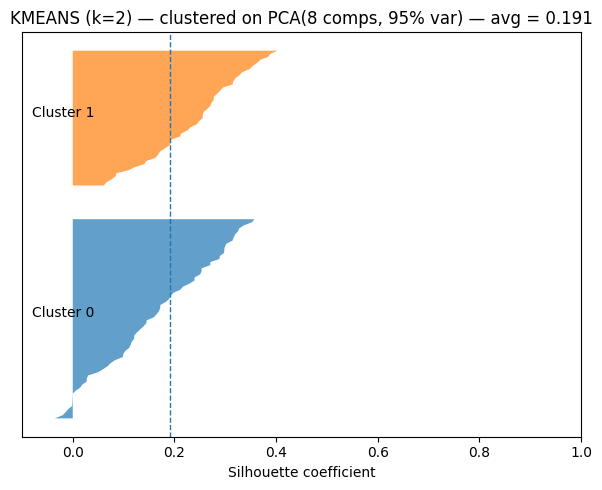

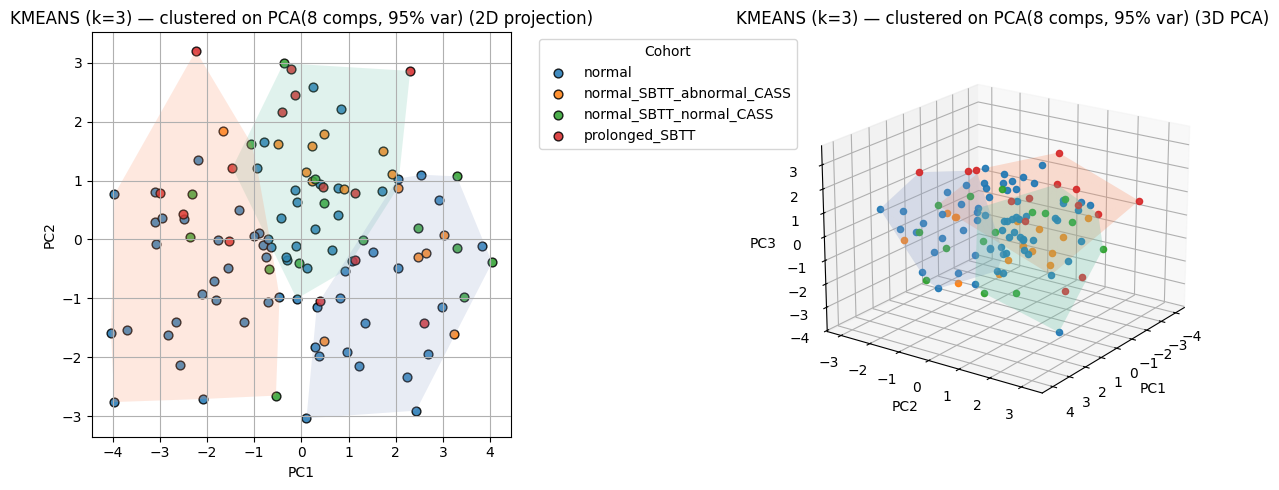

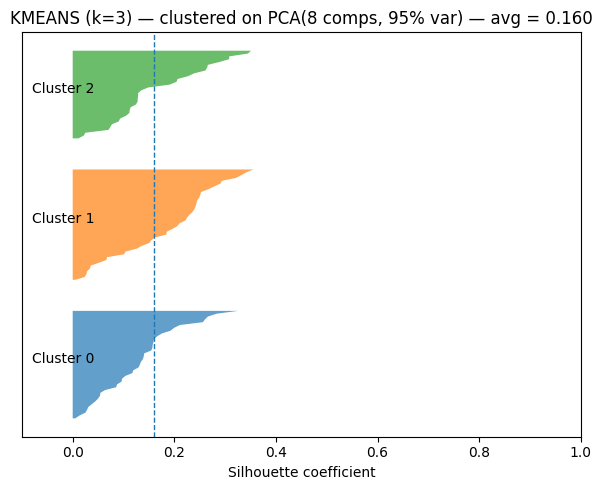

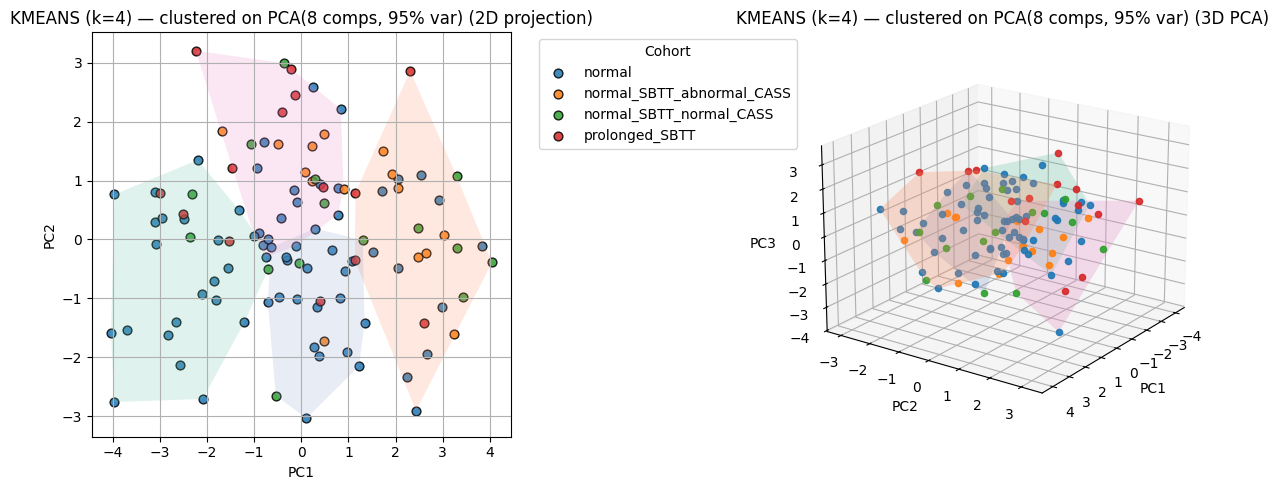

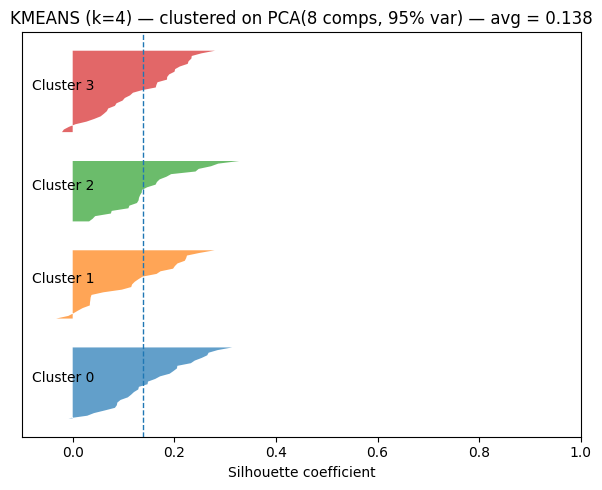

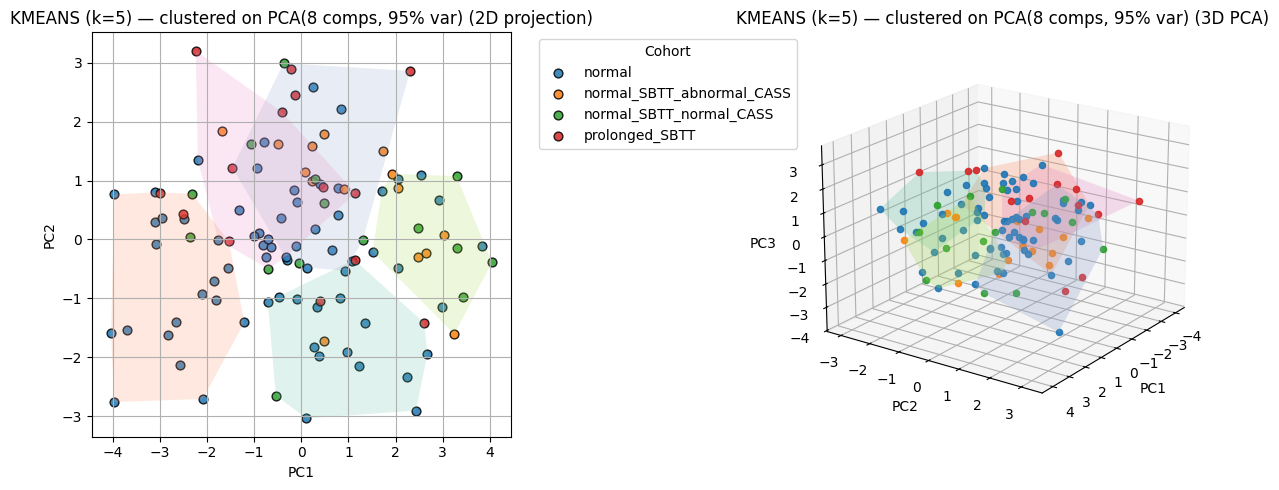

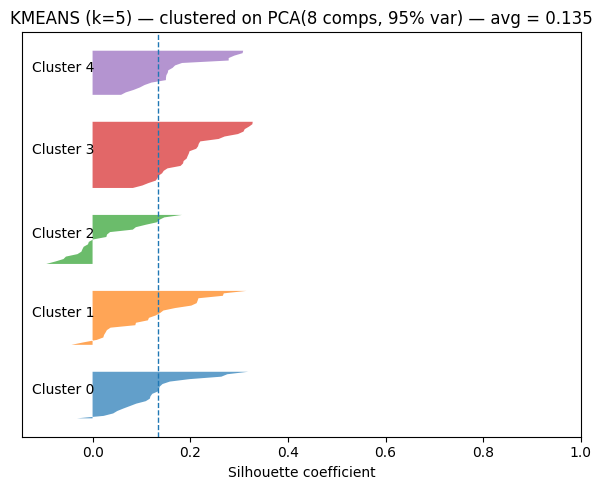

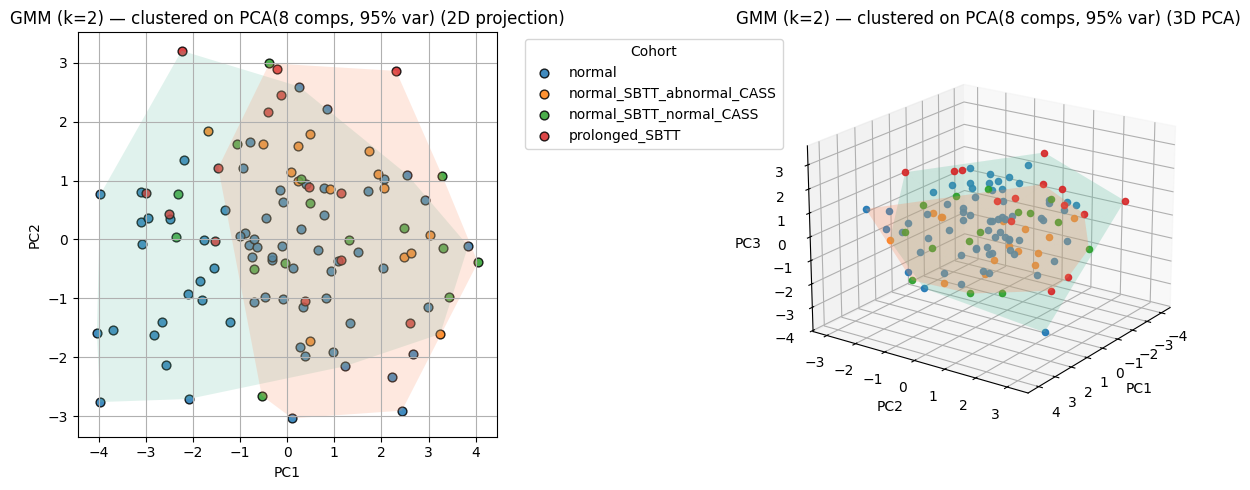

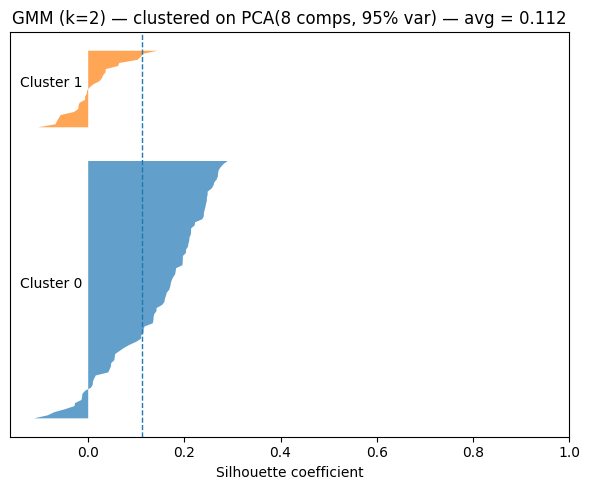

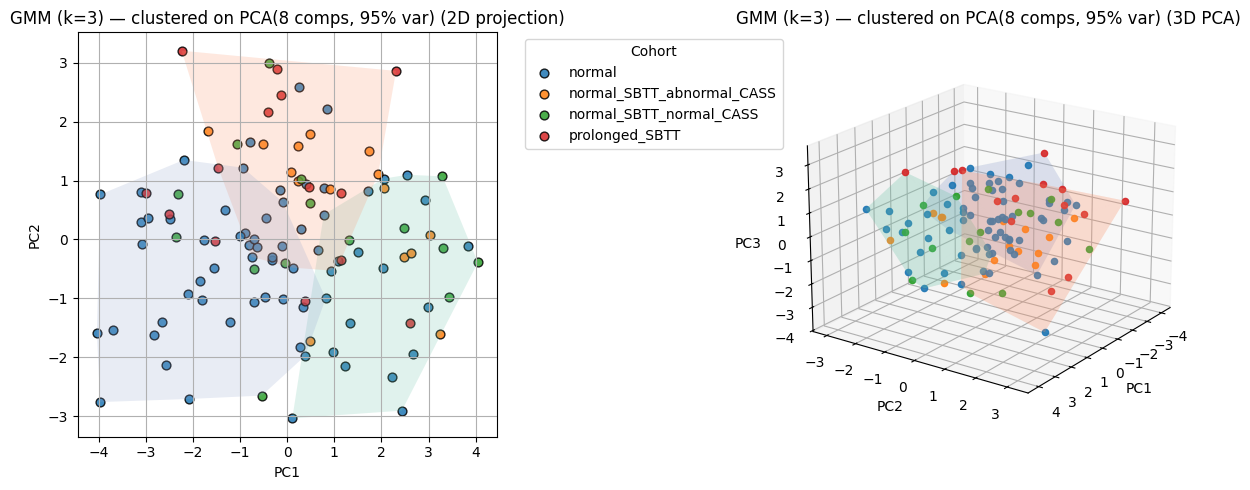

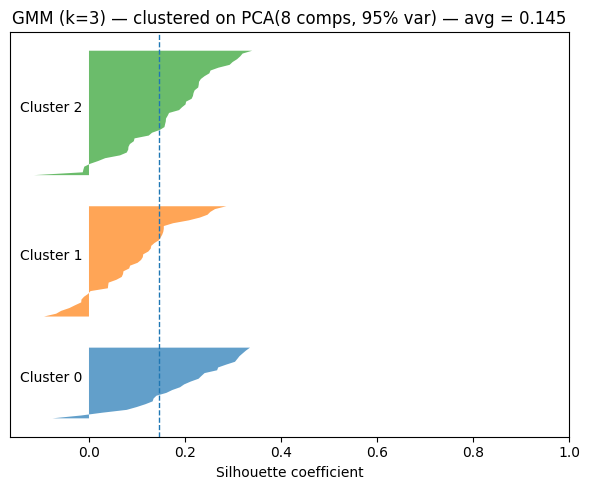

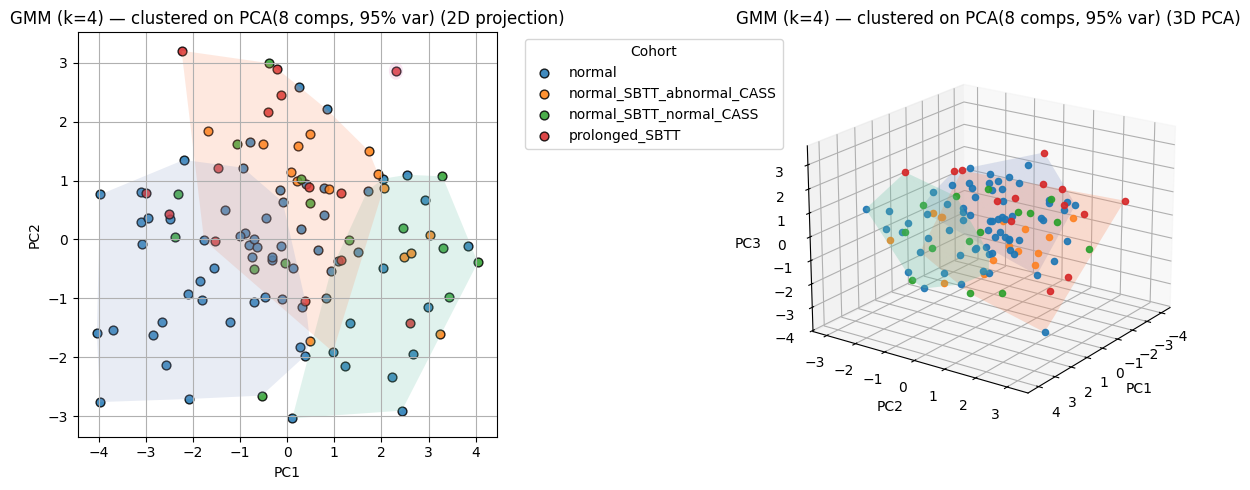

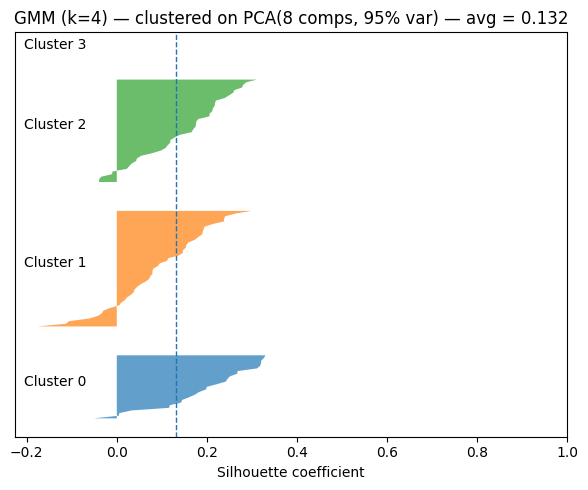

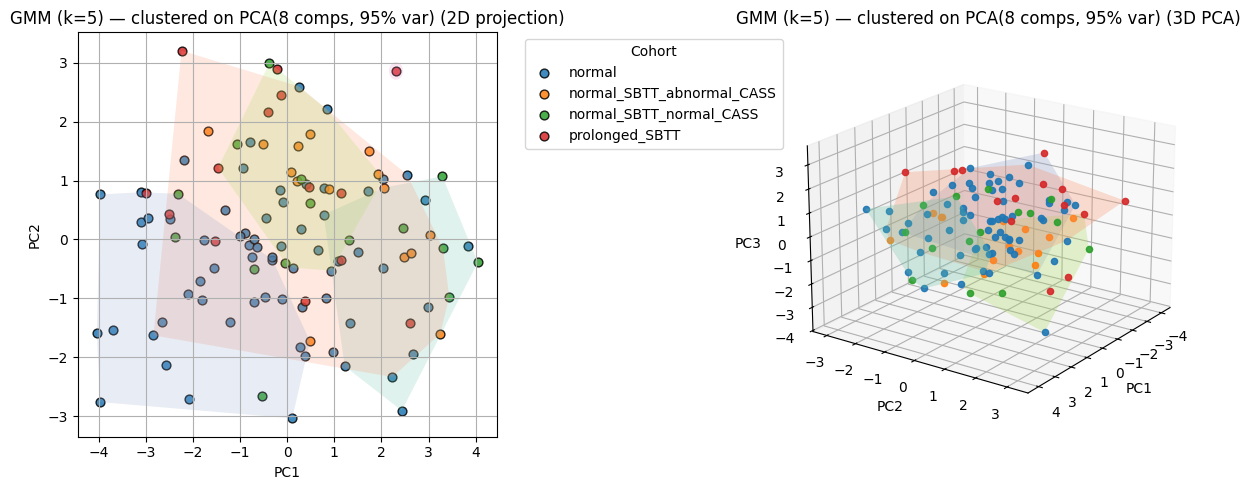

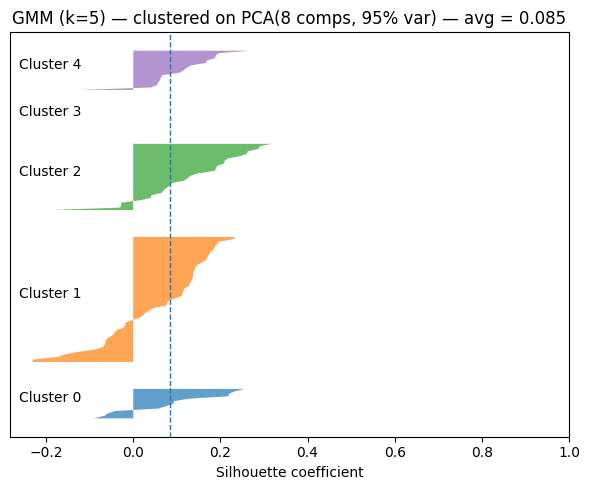

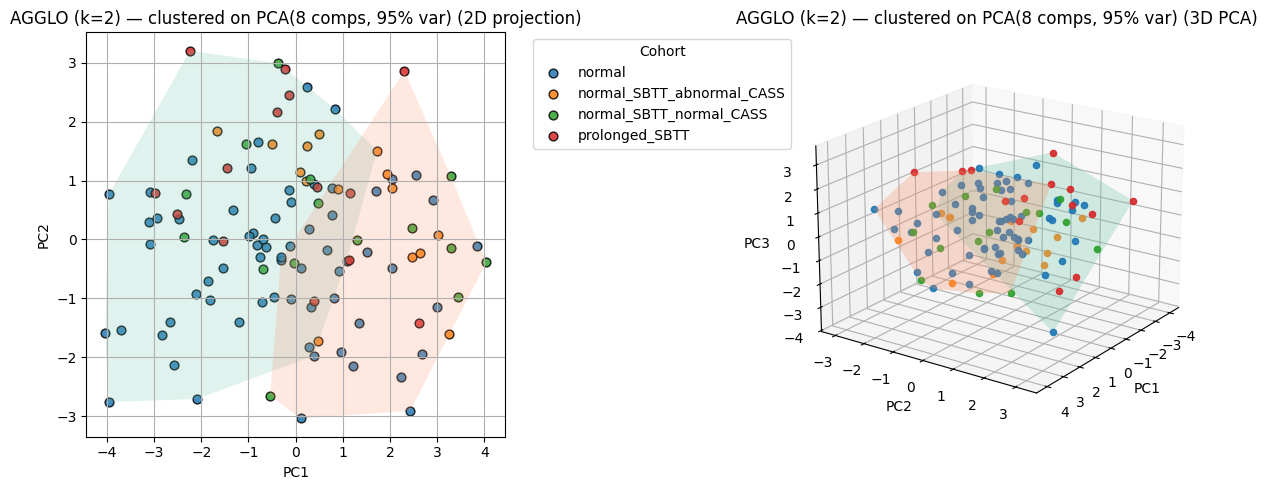

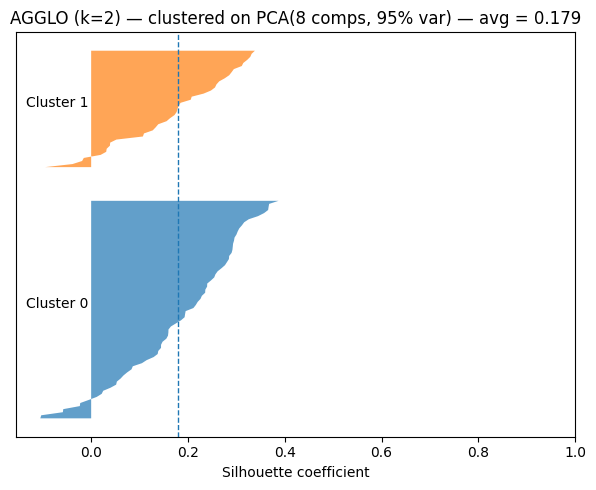

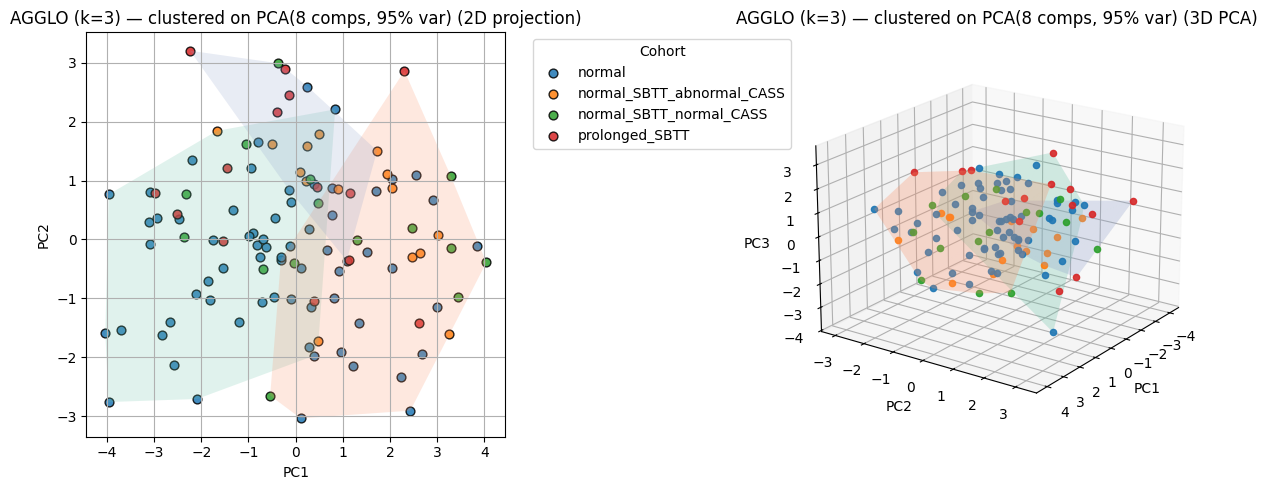

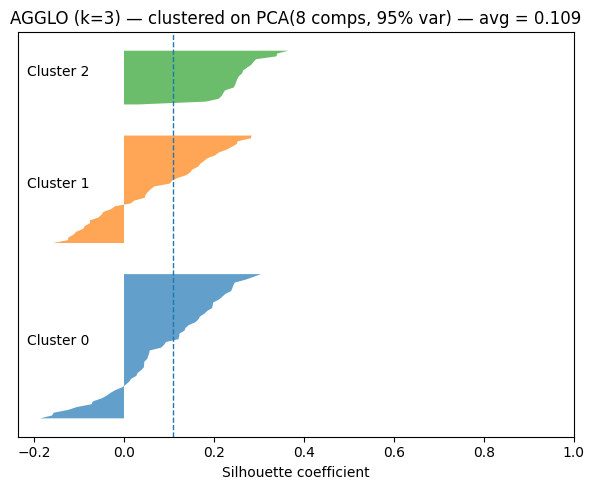

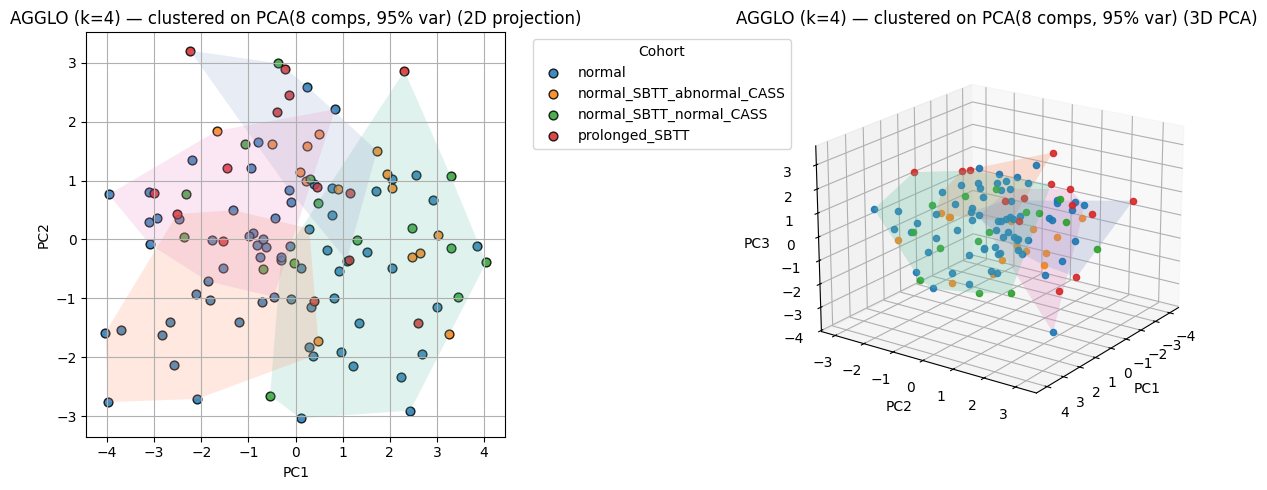

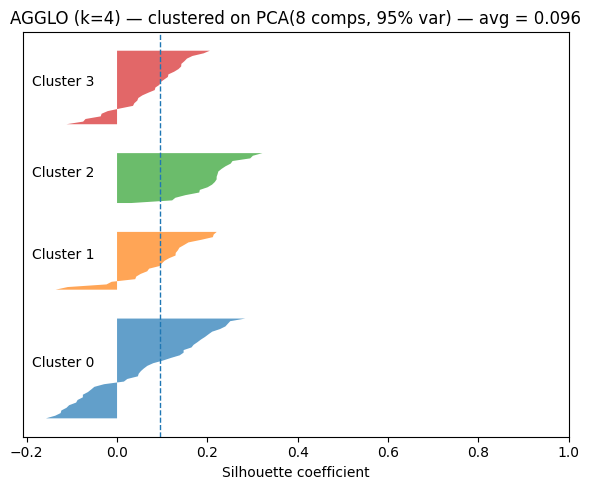

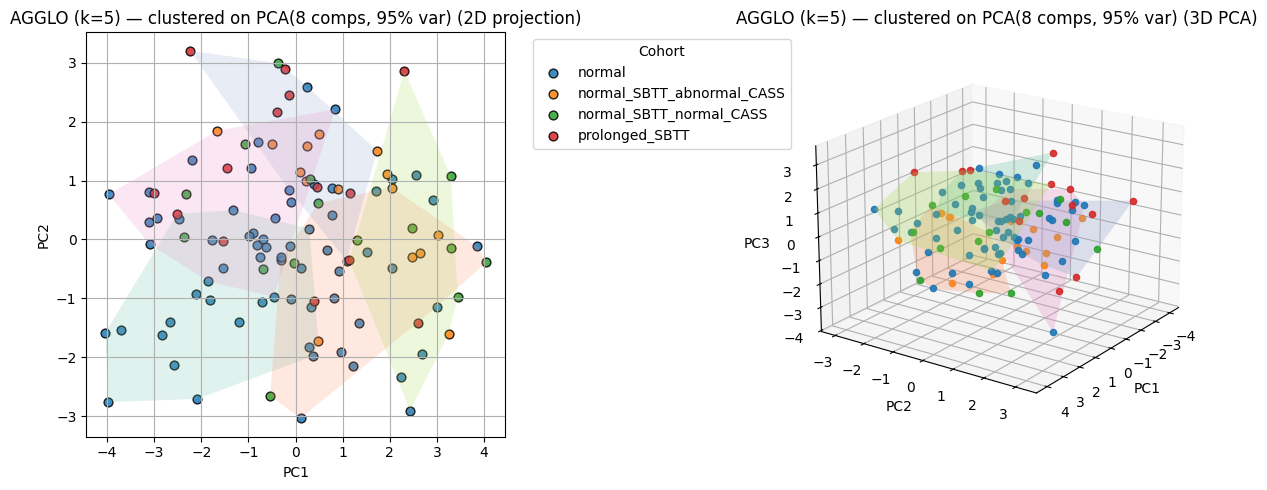

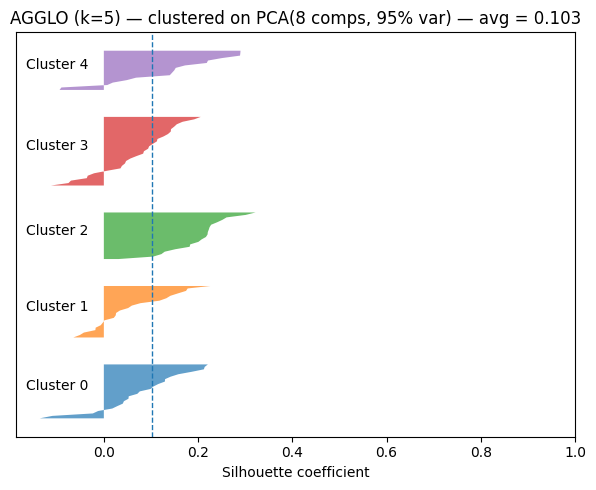

In [535]:
summary = cluster_and_plot_all(
    Z_df_no_metadata, gi_features, cohort_col,
    methods=("kmeans","gmm","agglo"),
    ks=(2,3,4,5),
    proj2='pca',                 
    cluster_on_pca_var=0.95,   
    show_silhouette=True
)